In [1]:
# star_wars_fan_clustering.py

import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Load dataset
# -----------------------------
df = pd.read_csv("star_wars_reviews.csv")

cols = ["fav_heroe","fav_villain","fav_film",
        "fav_soundtrack","fav_spaceship","fav_planet","fav_robot"]

def tok(x):
    return str(x).strip().lower().replace(" ", "_")

# Treat each fan as a "sentence" of tokens
sentences = df[cols].apply(lambda r: [f"{c}:{tok(r[c])}" for c in cols], axis=1).tolist()

# -----------------------------
# 2. Train Word2Vec
# -----------------------------
model = Word2Vec(
    sentences=sentences,
    vector_size=32,    # latent dimension
    window=6,          # context window (whole basket)
    min_count=5,       # ignore rare items
    workers=4,
    sg=1,              # skip-gram
    negative=10,
    epochs=30
)

item_vec = model.wv

# -----------------------------
# 3. Build fan vectors
# -----------------------------
def fan_vector(row):
    toks = [f"{c}:{tok(row[c])}" for c in cols if f"{c}:{tok(row[c])}" in item_vec]
    if not toks:
        return np.zeros(model.vector_size)
    return np.mean([item_vec[t] for t in toks], axis=0)

X = np.vstack(df.apply(fan_vector, axis=1).values)

# -----------------------------
# 4. K-Means clustering
# -----------------------------
best = None
for k in range(3, 10):  # test k = 3..9
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(X)
    s = silhouette_score(X, km.labels_)
    if best is None or s > best[0]:
        best = (s, k, km)

sil, k, kmeans = best
print(f"Best k = {k} (silhouette = {sil:.3f})")

df["cluster"] = kmeans.labels_
print(df["cluster"].value_counts())

# -----------------------------
# 5. Assign a new fan
# -----------------------------
new_fan = {
    "fav_heroe": "Luke Skywalker",
    "fav_villain": "Darth Vader",
    "fav_film": "The Empire Strikes Back",
    "fav_soundtrack": "Imperial March",
    "fav_spaceship": "X-Wing",
    "fav_planet": "Tatooine",
    "fav_robot": "R2-D2"
}

x_new = fan_vector(pd.Series(new_fan)).reshape(1, -1)
cluster_id = kmeans.predict(x_new)[0]
print("New fan belongs to cluster:", cluster_id)


KeyboardInterrupt: 

In [2]:
from sklearn.metrics import pairwise_distances_argmin_min
from numpy.linalg import norm

# Helper: cosine similarity
def cos_sim(a, b):
    return (a @ b) / (norm(a) * norm(b) + 1e-9)

# Prepack item matrix for fast search
vocab = item_vec.index_to_key
V = np.vstack([item_vec[w] for w in vocab])

# Map token -> field (tokens look like "fav_villain:darth_vader")
def token_field(token):
    return token.split(":")[0] if ":" in token else "unknown"

# Get top-N nearest tokens to a centroid (optionally restricted to a field)
def top_tokens_for_centroid(cvec, topn=10, field=None):
    sims = (V @ cvec) / (norm(V, axis=1) * norm(cvec) + 1e-9)
    order = np.argsort(-sims)
    out = []
    for idx in order:
        tok = vocab[idx]
        if (field is None) or (token_field(tok) == field):
            out.append((tok, float(sims[idx])))
            if len(out) == topn:
                break
    return out

print("\n=== Cluster anchors (nearest tokens by cosine) ===")
for c in range(k):
    cvec = kmeans.cluster_centers_[c]
    print(f"\nCluster {c}:")
    # overall top tokens
    for tok, s in top_tokens_for_centroid(cvec, topn=10):
        print(f"  {tok:35s}  sim={s:.3f}")
    # per-field top-3 for quick labeling
    for fld in cols:
        toks = top_tokens_for_centroid(cvec, topn=3, field=fld)
        nice = ", ".join([t.split(":")[1].replace("_"," ").title() for t,_ in toks])
        print(f"    {fld}: {nice}")



=== Cluster anchors (nearest tokens by cosine) ===

Cluster 0:
  fav_heroe:obi-wan_kenobi             sim=0.477
  fav_heroe:han_solo                   sim=0.477
  fav_villain:darth_vader              sim=0.476
  fav_heroe:anakin_skywalker           sim=0.476
  fav_villain:wilhuff_tarkin           sim=0.475
  fav_heroe:qui-gon_jinn               sim=0.475
  fav_heroe:luke_skywalker             sim=0.474
  fav_villain:general_grievous         sim=0.472
  fav_villain:palpatine                sim=0.471
  fav_heroe:yoda                       sim=0.469
    fav_heroe: Obi-Wan Kenobi, Han Solo, Anakin Skywalker
    fav_villain: Darth Vader, Wilhuff Tarkin, General Grievous
    fav_film: Episode Iv - A New Hope, Episode I - The Phantom Menace, Episode Vi - Return Of The Jedi
    fav_soundtrack: Star Wars (Main Theme), The Throne Room, Imperial March
    fav_spaceship: Millennium Falcon, Tie Fighter, Naboo Starfighter
    fav_planet: Dagobah, Naboo, Alderaan
    fav_robot: C-3Po, Battle Droid, 

In [6]:
# -----------------------------
# Spherical K-Means (cosine-based)
# -----------------------------
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Normalize fan embeddings to unit vectors
X_norm = normalize(X)

best = None
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_norm)
    s = silhouette_score(X_norm, labels, metric="cosine")  # cosine silhouette
    if best is None or s > best[0]:
        best = (s, k, km)

sil, k, kmeans = best
print(f"Spherical K-Means best k={k}, silhouette={sil:.3f} (cosine)")


Spherical K-Means best k=3, silhouette=0.166 (cosine)


In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
sil = silhouette_score(X, kmeans.labels_)
db = davies_bouldin_score(X, kmeans.labels_)
ch = calinski_harabasz_score(X, kmeans.labels_)
print(f"Silhouette: {sil:.3f}, Davies-Bouldin: {db:.3f}, Calinski-Harabasz: {ch:.1f}")


Silhouette: 0.092, Davies-Bouldin: 2.501, Calinski-Harabasz: 3918.6


In [3]:
# Most common values per field inside each cluster
print("\n=== Within-cluster top choices per field ===")
for c in range(k):
    print(f"\nCluster {c} (n={int((df['cluster']==c).sum())})")
    sub = df[df["cluster"] == c]
    for fld in cols:
        counts = sub[fld].value_counts().head(5)
        print(f"  {fld}:")
        for idx, val in counts.items():
            print(f"    {idx}  ({val})")



=== Within-cluster top choices per field ===

Cluster 0 (n=11802)
  fav_heroe:
    Obi-Wan Kenobi  (3299)
    Anakin Skywalker  (2043)
    Han Solo  (1920)
    Luke Skywalker  (1256)
    Qui-Gon Jinn  (963)
  fav_villain:
    Darth Vader  (4543)
    Palpatine  (2207)
    Wilhuff Tarkin  (1580)
    General Grievous  (1436)
    Darth Maul  (1030)
  fav_film:
    Episode V - The Empire Strikes Back  (3166)
    Episode IV - A New Hope  (2851)
    Episode I - The Phantom Menace  (2824)
    Episode VI - Return of the Jedi  (1587)
    Episode II - Attack of the Clones  (999)
  fav_soundtrack:
    Star Wars (Main Theme)  (7423)
    Imperial March  (2293)
    The Throne Room  (1556)
    Anakin vs. Obi-Wan  (293)
    Accross the Stars  (237)
  fav_spaceship:
    Millennium Falcon  (7931)
    Naboo Starfighter  (2296)
    TIE Fighter  (1242)
    Death Star  (333)
  fav_planet:
    Naboo  (4900)
    Tatooine  (3425)
    Dagobah  (1529)
    Endor  (1302)
    Alderaan  (646)
  fav_robot:
    C-3PO 

In [7]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins(X, m=None):
    if m is None:
        m = int(0.1 * X.shape[0])
    d = X.shape[1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.rand(m, d)
    ujd = []
    wjd = []
    for _ in range(m):
        i = np.random.randint(0, X.shape[0])
        u_dist, _ = nbrs.kneighbors(rand_X[_].reshape(1, -1), 2, return_distance=True)
        w_dist, _ = nbrs.kneighbors(X[i].reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][0])
        wjd.append(w_dist[0][1])
    return sum(ujd) / (sum(ujd) + sum(wjd))
print("Hopkins:", hopkins(X))


Hopkins: 0.9960806348182278


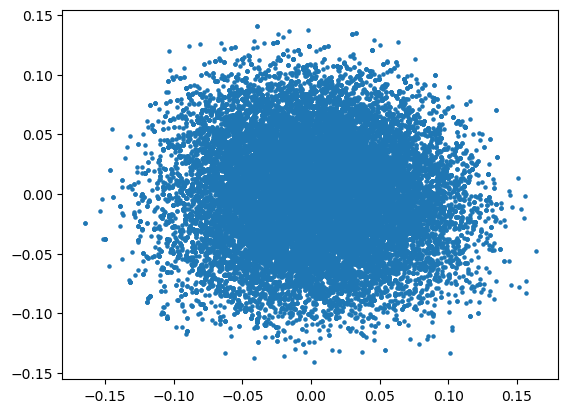

In [8]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pca = PCA(n_components=2)
Z = pca.fit_transform(X_norm)  # X_norm from spherical setup
plt.scatter(Z[:,0], Z[:,1], s=5)


In [10]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Columns to encode
cols = ["fav_heroe","fav_villain","fav_film",
        "fav_soundtrack","fav_spaceship","fav_planet","fav_robot"]

# One-hot encode
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # for sklearn >= 1.2
X_onehot = encoder.fit_transform(df[cols])

print("One-hot shape:", X_onehot.shape)

# Hopkins function
def hopkins(X, m=None):
    if m is None:
        m = int(0.1 * X.shape[0])
    d = X.shape[1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    rand_X = np.random.rand(m, d)
    ujd = []
    wjd = []
    for _ in range(m):
        i = np.random.randint(0, X.shape[0])
        u_dist, _ = nbrs.kneighbors(rand_X[_].reshape(1, -1), 2, return_distance=True)
        w_dist, _ = nbrs.kneighbors(X[i].reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][0])
        wjd.append(w_dist[0][1])
    return sum(ujd) / (sum(ujd) + sum(wjd))

print("Hopkins (one-hot):", hopkins(X_onehot))


One-hot shape: (36927, 39)
Hopkins (one-hot): 0.8712445373874287


In [ ]:
# -----------------------------
# Spectral Clustering on high-d embeddings (cosine k-NN graph)
# -----------------------------
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from scipy.sparse import csr_matrix
import warnings, time

# Use normalized embeddings for cosine geometry
Xn = normalize(X)  # shape (n_samples, d)

def spectral_cosine_knn(Xn, n_clusters=3, n_neighbors=20, gamma=10.0, assign_labels="kmeans"):
    """
    Build a sparse cosine k-NN affinity and run SpectralClustering.
    - n_neighbors: graph sparsity (10-50 is typical)
    - gamma: RBF width on cosine distance (affinity = exp(-gamma * d_cos^2))
             smaller gamma → broader connections; larger → tighter local links
    """
    t0 = time.time()
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric="cosine", n_jobs=-1)
    nn.fit(Xn)
    # distances D in [0, 2] for cosine (since cosine distance = 1 - cos_sim ∈ [0,2])
    D, idx = nn.kneighbors(Xn, return_distance=True)
    n = Xn.shape[0]
    row_ind = np.repeat(np.arange(n), n_neighbors)
    col_ind = idx.ravel()
    data = np.exp(-gamma * (D.ravel() ** 2))  # RBF on cosine distance
    W = csr_matrix((data, (row_ind, col_ind)), shape=(n, n))
    # Make symmetric (max to preserve strong links) and set self-affinity to 1
    W = W.maximum(W.T)
    W.setdiag(1.0)

    spec = SpectralClustering(
        n_clusters=n_clusters,
        affinity="precomputed",
        assign_labels=assign_labels,   # "kmeans" or "discretize"
        random_state=42,
        n_init=10,                     # more stable label assignment
        eigen_solver="arpack"          # or "lobpcg" (try if ARPACK struggles)
    )
    labels = spec.fit_predict(W)
    sil = np.nan
    try:
        sil = silhouette_score(Xn, labels, metric="cosine")
    except Exception:
        pass
    secs = time.time() - t0
    return labels, sil, secs

# Try a few neighbor/gamma settings and pick the best by cosine silhouette
search = []
for n_neighbors in (10, 20, 30, 40):
    for gamma in (5.0, 10.0, 20.0):
        try:
            labels, sil, secs = spectral_cosine_knn(Xn, n_clusters=3, n_neighbors=n_neighbors, gamma=gamma)
            search.append((n_neighbors, gamma, sil, secs))
            print(f"[Spectral] k=3, nn={n_neighbors}, gamma={gamma} -> silhouette(cos)={sil:.3f}, {secs:.1f}s")
        except Exception as e:
            warnings.warn(f"Spectral failed for nn={n_neighbors}, gamma={gamma}: {e}")

# Pick best config
if search:
    best = max(search, key=lambda t: (t[2] if t[2]==t[2] else -1))
    nn_best, gamma_best, sil_best, secs_best = best
    print(f"BEST Spectral: nn={nn_best}, gamma={gamma_best}, silhouette(cos)={sil_best:.3f} in {secs_best:.1f}s")
    labels, sil, _ = spectral_cosine_knn(Xn, n_clusters=3, n_neighbors=nn_best, gamma=gamma_best)
    df["spectral_cluster"] = labels
else:
    print("No successful Spectral run; falling back...")
    df["spectral_cluster"] = -1


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


[Spectral] k=3, nn=10, gamma=5.0 -> silhouette(cos)=-0.204, 501.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
pip install sentence-transformers

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

# =========================
# 1) Load & normalize schema
# =========================
# Expected columns per your dataset description:
# review_id, fav_heroe, fav_villain, fav_film, fav_soundtrack, fav_spaceship, fav_planet, fav_robot
df = pd.read_csv("star_wars_reviews.csv")

# Standardize column names (strip spaces, lower)
df.columns = [c.strip().lower() for c in df.columns]

# Map/rename to canonical internal names
rename_map = {
    "review_id": "review_id",
    "fav_heroe": "fav_hero",        # fix the typo
    "fav_villain": "fav_villain",
    "fav_film": "fav_film",
    "fav_soundtrack": "fav_soundtrack",
    "fav_spaceship": "fav_spaceship",
    "fav_planet": "fav_planet",
    "fav_robot": "fav_robot",
}
# Only rename the columns that exist (in case CSV already has correct names)
df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

needed = ["review_id","fav_hero","fav_villain","fav_film","fav_soundtrack","fav_spaceship","fav_planet","fav_robot"]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected column(s): {missing}. Present columns: {list(df.columns)}")

# Basic cleaning: ensure strings, strip whitespace, fill NAs
for c in needed:
    df[c] = df[c].astype(str).str.strip().replace({"nan": "", "None": ""})
    df[c] = df[c].fillna("")

# Optional: fix common typos you noticed (e.g., Accross -> Across)
df["fav_soundtrack"] = df["fav_soundtrack"].str.replace(r"\bAccross\b", "Across", regex=True)

# =========================
# 2) Build one text per row
# =========================
# You can weight fields by repeating or tagging (tags help encoders understand role).
# If you want to weight Film higher, for example, bump it in the template.
def row_to_text(row):
    parts = [
        f"Hero: {row['fav_hero']}",
        f"Villain: {row['fav_villain']}",
        f"Film: {row['fav_film']}",
        f"Soundtrack: {row['fav_soundtrack']}",
        f"Spaceship: {row['fav_spaceship']}",
        f"Planet: {row['fav_planet']}",
        f"Robot: {row['fav_robot']}",
    ]
    return " | ".join(parts)

texts = df.apply(row_to_text, axis=1).tolist()

# =========================
# 3) Pretrained text embeddings
# =========================
# Good default: small/fast 384-dim model; swap to all-mpnet-base-v2 for higher quality (slower).
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
emb = model.encode(texts, batch_size=256, show_progress_bar=True)
emb = normalize(emb)  # L2 normalize → cosine-friendly geometry

# =========================
# 4) (Optional) PCA denoise
# =========================
# Keeps up to 50 dims (or less if original < 50)
pca_dims = min(50, emb.shape[1])
pca = PCA(n_components=pca_dims, random_state=42)
X = pca.fit_transform(emb)

# =========================
# 5) Choose k with silhouette
# =========================
def pick_k(X, k_min=2, k_max=20):
    best_k, best_s = None, -1
    # Cap k to <= number of samples
    k_max = min(k_max, len(X) - 1)
    for k in range(k_min, max(k_min, k_max) + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = km.fit_predict(X)
        # Guard: silhouette needs > 1 label
        if len(set(labels)) > 1:
            s = silhouette_score(X, labels, metric="euclidean")
            if s > best_s:
                best_k, best_s = k, s
    return best_k, best_s

best_k, best_s = pick_k(X, k_min=2, k_max=15)
print(f"Chosen k = {best_k} (silhouette = {best_s:.3f})")

# =========================
# 6) Final K-Means
# =========================
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X)
df["cluster"] = labels

# =========================
# 7) Quick cluster summaries
# =========================
def mode_and_ratio(series):
    cnt = Counter(series)
    if not cnt:
        return ("", 0.0)
    top_item, top_count = cnt.most_common(1)[0]
    return top_item, top_count / max(1, len(series))

def summarize_cluster(c):
    sub = df[df["cluster"] == c]
    size = len(sub)
    hero_top, hero_ratio = mode_and_ratio(sub["fav_hero"])
    villain_top, villain_ratio = mode_and_ratio(sub["fav_villain"])
    film_top, film_ratio = mode_and_ratio(sub["fav_film"])
    ship_top, ship_ratio = mode_and_ratio(sub["fav_spaceship"])
    planet_top, planet_ratio = mode_and_ratio(sub["fav_planet"])
    robot_top, robot_ratio = mode_and_ratio(sub["fav_robot"])
    return {
        "cluster": c,
        "size": size,
        "top_hero": f"{hero_top} ({hero_ratio:.0%})",
        "top_villain": f"{villain_top} ({villain_ratio:.0%})",
        "top_film": f"{film_top} ({film_ratio:.0%})",
        "top_spaceship": f"{ship_top} ({ship_ratio:.0%})",
        "top_planet": f"{planet_top} ({planet_ratio:.0%})",
        "top_robot": f"{robot_top} ({robot_ratio:.0%})",
    }

summaries = [summarize_cluster(c) for c in sorted(df["cluster"].unique())]
summary_df = pd.DataFrame(summaries)
print("\n=== Cluster Summaries ===")
print(summary_df.to_string(index=False))

# =========================
# 8) Save results
# =========================
df.to_csv("star_wars_reviews_clustered.csv", index=False)
summary_df.to_csv("star_wars_cluster_summaries.csv", index=False)
print("\nWrote star_wars_reviews_clustered.csv and star_wars_cluster_summaries.csv")


Batches:   0%|          | 0/145 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


: 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Load & prep data
# -----------------------------
df = pd.read_csv("star_wars_reviews.csv")

cols = ["fav_heroe","fav_villain","fav_soundtrack",
        "fav_spaceship","fav_planet","fav_robot"]
target = "fav_film"

X = df[cols].astype(str)
y = df[target].astype(str)

# One-hot encode for CART
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_enc = enc.fit_transform(X)

# -----------------------------
# 2. Train CART to get feature importance
# -----------------------------
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_enc, y)

importances = tree.feature_importances_
feat_names = enc.get_feature_names_out(cols)

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\nTop features by importance:\n", feat_imp.head(15))

# -----------------------------
# 3. Select Top Predictors
# -----------------------------
# pick top N (e.g., top 20 one-hot columns)
top_features = feat_imp.head(8).index
top_idx = [list(feat_names).index(f) for f in top_features]

X_top = X_enc[:, top_idx]  # reduced feature space

# Normalize for cosine geometry
Xn = normalize(X_top)

# -----------------------------
# 4. Cluster on selected features
# -----------------------------
best = None
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init="auto", random_state=42).fit(Xn)
    s = silhouette_score(Xn, km.labels_, metric="cosine")
    if best is None or s > best[0]:
        best = (s, k, km)

sil, k, kmeans = best
print(f"[Clusters on top CART features] k={k}, silhouette(cos)={sil:.3f}")

df["cart_cluster"] = kmeans.labels_
print(df["cart_cluster"].value_counts())



Top features by importance:
 fav_planet_Tatooine                      0.109570
fav_spaceship_TIE Fighter                0.100934
fav_villain_Darth Maul                   0.080921
fav_planet_Alderaan                      0.072361
fav_villain_Darth Vader                  0.071119
fav_soundtrack_The Throne Room           0.068996
fav_heroe_Yoda                           0.046776
fav_robot_Droideka                       0.042289
fav_spaceship_Death Star                 0.041565
fav_villain_Wilhuff Tarkin               0.041306
fav_heroe_Jar Jar Binks                  0.036701
fav_robot_R2-D2                          0.034607
fav_soundtrack_Star Wars (Main Theme)    0.031658
fav_robot_C-3PO                          0.030524
fav_soundtrack_Accross the Stars         0.027855
dtype: float64
[Clusters on top CART features] k=9, silhouette(cos)=0.399
cart_cluster
1    9489
0    7180
2    5280
3    5037
5    2809
6    2590
7    1809
4    1467
8    1266
Name: count, dtype: int64


In [2]:
from sklearn.metrics import davies_bouldin_score

# Davies–Bouldin Index
dbi = davies_bouldin_score(Xn, kmeans.labels_)
print(f"Davies–Bouldin Index (DBI): {dbi:.3f}")


Davies–Bouldin Index (DBI): 1.968


In [5]:
pip install KModes

Note: you may need to restart the kernel to use updated packages.


In [2]:
from kmodes.kmodes import KModes
import pandas as pd
df = pd.read_csv("star_wars_reviews.csv")

cols = ["fav_heroe","fav_villain","fav_film",
        "fav_soundtrack","fav_spaceship","fav_planet","fav_robot"]

# Use original categorical data
X_cat = df[cols].astype(str)

# Fit K-Modes
km = KModes(n_clusters=6, init='Cao', n_init=5, verbose=1, random_state=42)
clusters = km.fit_predict(X_cat)

df["kmodes_cluster"] = clusters
print(df["kmodes_cluster"].value_counts())

# Check cluster "modes" (most representative profiles)
for i, mode in enumerate(km.cluster_centroids_):
    print(f"\nCluster {i} centroid:")
    for c, val in zip(cols, mode):
        print(f"  {c}: {val}")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 118430.0
kmodes_cluster
0    14608
1     8508
2     4610
3     3276
4     3161
5     2764
Name: count, dtype: int64

Cluster 0 centroid:
  fav_heroe: Obi-Wan Kenobi
  fav_villain: Darth Vader
  fav_film: Episode V - The Empire Strikes Back
  fav_soundtrack: Star Wars (Main Theme)
  fav_spaceship: Millennium Falcon
  fav_planet: Naboo
  fav_robot: R2-D2

Cluster 1 centroid:
  fav_heroe: Han Solo
  fav_villain: Palpatine
  fav_film: Episode IV - A New Hope
  fav_soundtrack: Imperial March
  fav_spaceship: Millennium Falcon
  fav_planet: Tatooine
  fav_robot: C-3PO

Cluster 2 centroid:
  fav_heroe: Anakin Skywalker
  fav_villain: Darth Maul
  fav_film: Episode VI - Return of the Jedi
  fav_soundtrack: Imperial March
  fav_spaceship: Millennium Falcon
  fav_planet: Endor
  fav_robot: R2-D2

Clust

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score

# --- Inputs you already have ---
# df, cols, X_cat (df[cols].astype(str)), clusters from KModes

# 1) Take a stratified-ish subsample to keep cluster proportions
rng = np.random.default_rng(42)
max_n = 5000  # adjust if you have more RAM; 5k is usually safe
idxs = []

for k in np.unique(clusters):
    k_idx = np.where(clusters == k)[0]
    take = min(len(k_idx), max_n // len(np.unique(clusters)) + 1)
    idxs.extend(rng.choice(k_idx, size=take, replace=False))
idxs = np.array(sorted(set(idxs)))  # unique + sorted

X_sub = X_cat.iloc[idxs].to_numpy(object)       # shape: (n_sub, n_features)
y_sub = clusters[idxs]

# 2) Build a pairwise dissimilarity matrix (simple matching) in CHUNKS to limit RAM
def matching_dissim_blockwise(X, block=1000):
    n = X.shape[0]
    D = np.zeros((n, n), dtype=np.uint16)  # uint16 is fine if features < 65535
    for i in range(0, n, block):
        X_i = X[i:i+block]
        # Compare X_i to ALL rows X (broadcasts to (bi, n, f))
        diff = (X_i[:, None, :] != X[None, :, :])
        # Sum mismatches across features -> (bi, n)
        D[i:i+block, :] = diff.sum(axis=2, dtype=np.uint16)
    # Make explicitly symmetric with zero diagonal (paranoia)
    D = np.minimum(D, D.T)
    np.fill_diagonal(D, 0)
    return D

D_sub = matching_dissim_blockwise(X_sub, block=800)  # tune block size to your RAM

# 3) Silhouette with the precomputed categorical distance
sil = silhouette_score(D_sub, y_sub, metric="precomputed")
print(f"Silhouette (simple-matching on categories, subsample n={len(X_sub)}): {sil:.3f}")


Silhouette (simple-matching on categories, subsample n=5004): 0.079


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# -----------------------------
# 1. Load & prep data
# -----------------------------
df = pd.read_csv("star_wars_reviews.csv")

cols = ["fav_heroe","fav_villain","fav_soundtrack",
        "fav_spaceship","fav_planet","fav_robot"]
target = "fav_film"

X = df[cols].astype(str)
y = df[target].astype(str)

# One-hot encode for CART
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_enc = enc.fit_transform(X)

# -----------------------------
# 2. Train CART to get feature importance
# -----------------------------
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_enc, y)

importances = tree.feature_importances_
feat_names = enc.get_feature_names_out(cols)

feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("\n🌟 Top features by importance (CART):")
print(feat_imp.head(15).to_string())

# -----------------------------
# 3. Select Top Predictors
# -----------------------------
top_features = feat_imp.head(8).index
top_idx = [list(feat_names).index(f) for f in top_features]

X_top = X_enc[:, top_idx]  # reduced feature space

# Normalize for cosine geometry
Xn = normalize(X_top)

# -----------------------------
# 4. Cluster on selected features
# -----------------------------
best = None
for k in range(3, 10):
    km = KMeans(n_clusters=k, n_init=20, random_state=42).fit(Xn)
    s = silhouette_score(Xn, km.labels_, metric="cosine")
    if best is None or s > best[0]:
        best = (s, k, km)

sil, k, kmeans = best
labels = kmeans.labels_
df["cart_cluster"] = labels

print(f"\n✅ Best clustering: k={k}, silhouette(cos)={sil:.3f}")

# -----------------------------
# 5. Cluster summary
# -----------------------------
cluster_sizes = pd.Series(labels).value_counts().sort_index()
print("\n📊 Cluster size distribution:")
print((cluster_sizes.to_frame("count")
       .assign(percent=lambda x: 100*x["count"]/len(df))
       .round(1)))

# -----------------------------
# 6. Interpret clusters: top features
# -----------------------------
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=top_features)

print("\n🔎 Top categories per cluster:")
for cid in range(k):
    print(f"\n--- Cluster {cid} (n={cluster_sizes[cid]}, {cluster_sizes[cid]/len(df)*100:.1f}%) ---")
    top = centroids.loc[cid].sort_values(ascending=False).head(5)
    for feat, val in top.items():
        cat = feat.split("_", 1)[1]  # remove prefix (fav_villain_, etc.)
        print(f"  {cat:25s}  {val:.2f}")



🌟 Top features by importance (CART):
fav_planet_Tatooine                      0.109570
fav_spaceship_TIE Fighter                0.100934
fav_villain_Darth Maul                   0.080921
fav_planet_Alderaan                      0.072361
fav_villain_Darth Vader                  0.071119
fav_soundtrack_The Throne Room           0.068996
fav_heroe_Yoda                           0.046776
fav_robot_Droideka                       0.042289
fav_spaceship_Death Star                 0.041565
fav_villain_Wilhuff Tarkin               0.041306
fav_heroe_Jar Jar Binks                  0.036701
fav_robot_R2-D2                          0.034607
fav_soundtrack_Star Wars (Main Theme)    0.031658
fav_robot_C-3PO                          0.030524
fav_soundtrack_Accross the Stars         0.027855

✅ Best clustering: k=9, silhouette(cos)=0.450

📊 Cluster size distribution:
   count  percent
0   3144      8.5
1   5829     15.8
2   9774     26.5
3   4032     10.9
4   2233      6.0
5   2942      8.0
6   2626 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


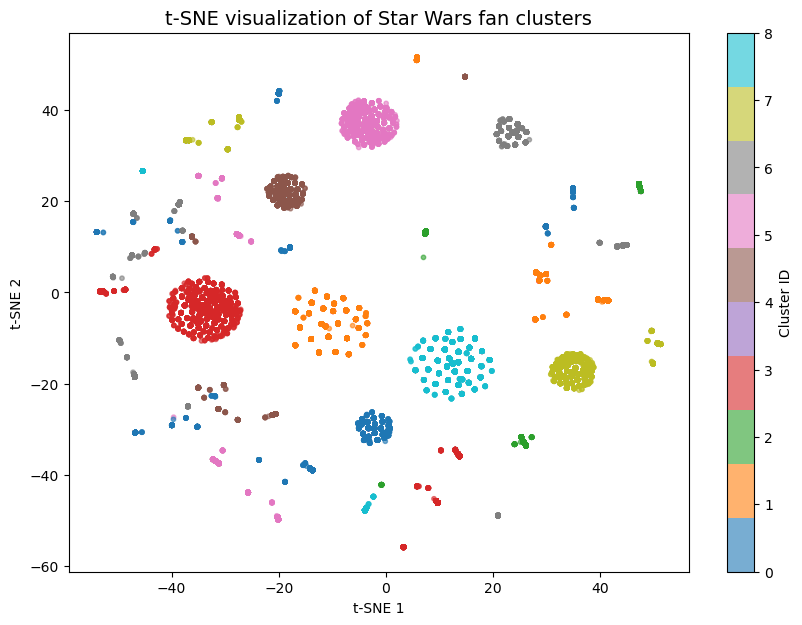

In [3]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -----------------------------
# t-SNE projection
# -----------------------------
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200,
            random_state=42, n_iter=1000, init="random")
X_tsne = tsne.fit_transform(Xn)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(10,7))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="tab10", alpha=0.6, s=10)
plt.title("t-SNE visualization of Star Wars fan clusters", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(k), label="Cluster ID")
plt.show()


In [ ]:
# Extract top 5 features for each cluster
centroid_summary = {}
for cid in range(k):
    top = centroids.loc[cid].sort_values(ascending=False).head(5)
    centroid_summary[f"Cluster {cid}"] = top.index.str.replace(".*_", "", regex=True).tolist()

centroid_df = pd.DataFrame.from_dict(centroid_summary, orient="index")
print(centroid_df)

# Save to CSV
centroid_df.to_csv("star_wars_cluster_archetypes.csv")
